# Kaggle Project: Real or Not? Natural Language Processing with Disaster Tweets

Disaster relief organisations and news agencies programmatically monitor Twitter to receive real-time information about emergencies and disasters. This notebook uses a voting classifier that trains on an ensemble of models (Multinomial Naive Bayes, Logistic Regression, Random Forest) to predict whether a given tweet is about a disaster. The F1 score of this classifier on the test set is 0.80294 (Kaggle public score). 

# Acknowledgements
https://www.youtube.com/watch?v=I3FBJdiExcg - This project was modelled after Ken Jee's Beginner Walk-Through for the Titanic Kaggle Competition

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/saga21/disaster-tweets-comp-introduction-to-nlp

https://www.kaggle.com/yurimuniz/classifying-tweets-step-by-step

# 1) Import important libraries and packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation

# Import NLTK packages - natural language processing
import nltk
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Import scikit learn - machine learning
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


# 2) Load datasets

In [2]:
training = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['target'] = np.NaN
all_data = pd.concat([training, test], sort=True)

In [3]:
all_data.head()

,id,keyword,location,target,text,train_test
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
all_data.info()
# There is some missing info in the keyword column and a lot missing in the location column 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          10876 non-null  int64  
 1   keyword     10789 non-null  object 
 2   location    7238 non-null   object 
 3   target      7613 non-null   float64
 4   text        10876 non-null  object 
 5   train_test  10876 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 594.8+ KB


# 3) Exploratory data analysis of entire dataset

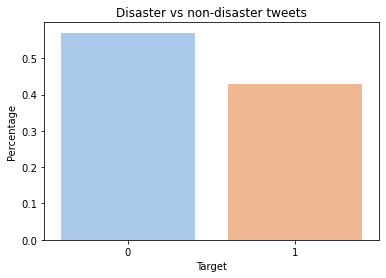

In [5]:
# First, we want to check if the target class is balanced or unbalanced in the training data
# i.e. if there are far more disaster tweets that non-disaster tweets
sns.set_palette("pastel")
ax = sns.barplot(training['target'].value_counts().index, training['target'].value_counts()/len(training))
ax.set_title("Disaster vs non-disaster tweets")
ax.set_ylabel("Percentage")
ax.set_xlabel("Target");

#Target class is fairly balanced

In [6]:
# Investigate the 'keyword' column
print('There are {} unique values in the keyword column'.format(len(all_data['keyword'].unique())))
print('The first 10 keywords are '+str(all_data['keyword'].unique().tolist()[:10]))
print("\n")

# Investigate the 'location' column
print('There are {} unique values in the location column'.format(len(all_data['location'].unique())))
print('The first 10 locations are '+str(all_data['location'].unique().tolist()[:10]))

# The keyword column seems more useful than the location column. There are way more unique values in the location column and the values are not entered in a consistent manner

There are 222 unique values in the keyword column
The first 10 keywords are [nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon']


There are 4522 unique values in the location column
The first 10 locations are [nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


In [7]:
# Extract meta features from the 'text' column

all_data['word_count'] = all_data['text'].apply(lambda x:len(str(x).split()))
all_data['unique_word_count'] = all_data['text'].apply(lambda x:len(set(str(x).split())))
all_data['mean_word_length'] = all_data['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
all_data['character_count'] = all_data['text'].apply(lambda x:len(str(x)))
all_data['digit_count'] = all_data['text'].apply(lambda x: np.sum([len(char) for char in x if char.isdigit() == True]))
all_data['non_word_char_count'] = all_data['text'].apply(lambda x: len(re.findall('r\W',x)))
all_data['number_of_URLs'] = all_data['text'].apply(lambda x:len(re.findall(r'http\S+|www\.\S+',x)))
all_data['number_of_hashtags'] = all_data['text'].apply(lambda x: len(re.findall('#',x)))
all_data['number_of_mentions'] = all_data['text'].apply(lambda x: len(re.findall('@',x)))

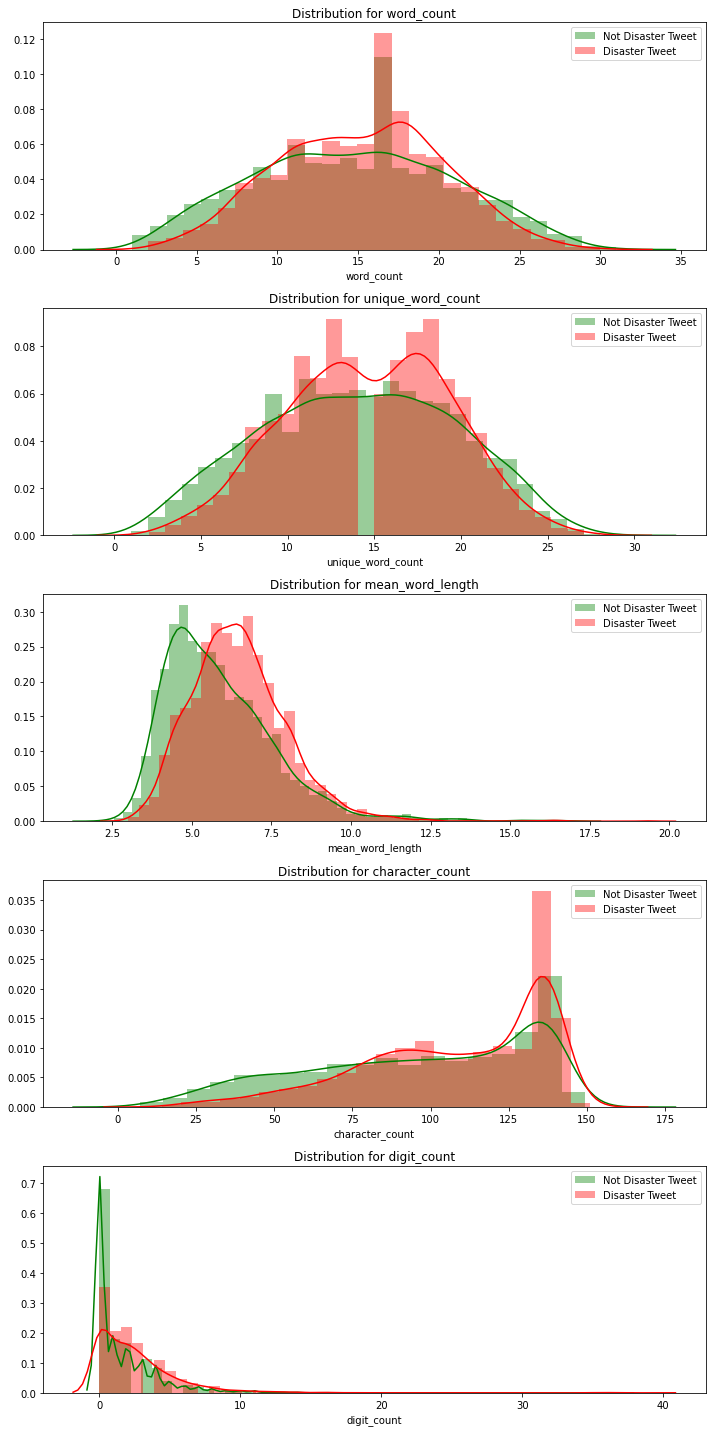

In [8]:
# Plot distributions of some of these meta features to make differences between both classes apparent
list_of_meta_features_1 = ['word_count','unique_word_count','mean_word_length','character_count','digit_count']
disaster_tweets = all_data['target'] == 1
not_disaster_tweets = all_data['target'] == 0

fig,axes = plt.subplots(nrows=len(list_of_meta_features_1),figsize=(10,20))
for i, feature in enumerate(list_of_meta_features_1):
    sns.distplot(all_data.loc[not_disaster_tweets][feature], label = 'Not Disaster Tweet',color = 'green',ax = axes[i]).set_title('Distribution for '+feature)
    sns.distplot(all_data.loc[disaster_tweets][feature], label = 'Disaster Tweet',color = 'red',ax = axes[i])
    axes[i].legend()
plt.tight_layout()

# 4) Text pre-processing

In [9]:
# Define dictionary of contractions
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}



In [10]:
# Write function to pre-process text
def pre_processing(text):
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace contractions
    for word in text.split():
        if word in contractions:
            text = text.replace(word,contractions[word.lower()])
            
    # Use regex to remove URLs
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    
    # Use regex to remove special characters
    text = re.sub("[^a-zA-Z]"," ",text)
    
    tokens = word_tokenize(text)
    
    # Use stemmer to obtain root words
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    single_string = ' '.join(stemmed_tokens)
    return single_string

all_data['text_clean'] = all_data['text'].apply(lambda x:pre_processing(x))

# 5) Scale the additional features between 0 and 1 using MinMax Scaler

In [11]:
all_data_scaled = all_data.copy()
all_data_scaled[['word_count','unique_word_count','mean_word_length','character_count','digit_count','non_word_char_count','number_of_hashtags','number_of_URLs','number_of_mentions']] = scale.fit_transform(all_data_scaled[['word_count','unique_word_count','mean_word_length','character_count','digit_count','non_word_char_count','number_of_hashtags','number_of_URLs','number_of_mentions']])

# 6) Convert the values in the keyword column into dummy variables

In [12]:
all_data_scaled.keyword = all_data_scaled.keyword.fillna('no_keyword')
all_data_dummies = pd.get_dummies(all_data_scaled,columns=['keyword'])

# 7) Run different classification algorithms on the vectorized training set and evaluate performance using 5-fold cross validation

In [13]:
training_additional_features = all_data_dummies[all_data_dummies['train_test']==1].drop(['id', 'location', 'text', 'text_clean','target','train_test'],axis=1)
test_additional_features = all_data_dummies[all_data_dummies['train_test']==0].drop(['id', 'location', 'text', 'text_clean','target','train_test'],axis=1)

X_train = all_data_dummies[all_data_dummies['train_test']==1].text_clean
y_train = all_data_dummies[all_data_dummies['train_test']==1].target
X_test = all_data_dummies[all_data_dummies['train_test']==0].text_clean

In [14]:
vect = TfidfVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

In [15]:
# Function to add additional features to sparse matrix

def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack   
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

for feature in training_additional_features.columns:
    X_train_vectorized = add_feature(X_train_vectorized, training_additional_features[feature])
    X_test_vectorized = add_feature(X_test_vectorized, test_additional_features[feature])

In [16]:
# Convert sparse matrix to array

X_train_array = X_train_vectorized.toarray()
X_test_array = X_test_vectorized.toarray()

In [17]:
# Using Multinomial Naive Bayes classifier model

nb = MultinomialNB()
nb_cv = cross_val_score(nb, X_train_array,y_train, cv=5)
print(nb_cv)
print(nb_cv.mean())

[0.667761   0.54432042 0.61523309 0.65768725 0.69710907]
0.6364221662929259


In [18]:
# Using logistic regression
lr = LogisticRegression(max_iter = 2000, solver='liblinear')
lr_cv = cross_val_score(lr,X_train_array,y_train,cv=5)
print(lr_cv)
print(lr_cv.mean())

[0.70124754 0.55876559 0.62508207 0.64388962 0.71550591]
0.6488981478046216


In [19]:
rf = RandomForestClassifier(random_state = 1)
rf_cv = cross_val_score(rf,X_train_array,y_train,cv=5)
print(rf_cv)
print(rf_cv.mean())

[0.71831911 0.67038739 0.67695338 0.67674113 0.74704336]
0.6978888751797881


# 8) Use voting classifier to aggregate the effects of different classifiers

In [20]:
# Use voting classifier to aggregate effects of different classifiers
voting_clf = VotingClassifier(estimators = [('lr',lr),('nb',nb),('rf',rf)], voting = 'hard')
cv = cross_val_score(voting_clf,X_train_array,y_train,cv=5)
print(cv)
print(cv.mean())

[0.70124754 0.56204859 0.63493106 0.65637319 0.71879106]
0.6546782881493837


In [21]:
voting_clf.fit(X_train_array,y_train)
predictions = voting_clf.predict(X_test_array).astype(int)
submission = pd.DataFrame({'id':test.id,'target':predictions})
submission.to_csv('submission_v7.csv', index =False)